## 필요한 모듈 설치 확인

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import random
import os
import pickle
import time
from tqdm import tqdm
from collections import deque
from replay_memory import ReplayBuffer, PrioritizedReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv

## 하이퍼 파라미터 정의하기

In [2]:
'''SAC Settings'''
# coefficient of entropy regularization
ENT_COEF = 1e-3
# experience replay memory size
MEMORY_CAPACITY = int(1e+3)
# learn start
LEARN_START = int(1e+3)
# learn frequency
LEARN_FREQ = 4

'''RND Settings'''
RND_START = LEARN_START

'''Environment Settings'''
# sequential images to define state
STATE_LEN = 4
# openai gym env name
ENV_NAME = 'MontezumaRevengeNoFrameskip-v4'
# number of environments for SAC
N_ENVS = 32
# define gym 
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
# check gym setting
N_ACTIONS = env.action_space.n;print('N_ACTIONS : ',N_ACTIONS) #  4
N_STATES = env.observation_space.shape;print('N_STATES : ',N_STATES) # (4, 84, 84)
# Total simulation step
N_STEP = int(1e+7)
# gamma for MDP
GAMMA = 0.9999
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 128
# learning rage
LR = 1e-4
# clip gradient
MAX_GRAD_NORM = 0.1

'''Save&Load Settings'''
# log frequency
LOG_FREQ = int(1e+3)
# check save/load
SAVE = True
LOAD = False
# paths for predction net, target net, result log
ACTOR_PATH = './data/model/actor_net.pkl'
CRITIC_PATH = './data/model/critic_net.pkl'
ACTION_CRITIC_PATH = './data/model/action_critic_net.pkl'
PRED_PATH = './data/model/pred_net.pkl'

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow')

N_ACTIONS :  18
N_STATES :  (4, 84, 84)
USE GPU: True


/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset'

Traceback (most recent call last):
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/sungyubkim/anaco

  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/sungyubkim/Dropbox/Deep_RL_with_pytorch/5_Exploration_Techinques/wrappers.py", line 270, in worker
    cmd, data = remote.recv()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
Traceback (most recent call last):
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "

  File "/home/sungyubkim/Dropbox/Deep_RL_with_pytorch/5_Exploration_Techinques/wrappers.py", line 270, in worker
    cmd, data = remote.recv()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/sungyubkim/Dropbox/Deep_RL_with_pytorch/5_Exploration_Techinques/wrappers.py", line 270, in worker
    cmd, data = remote.recv()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sungyubkim/Dropbox/Deep_RL_with_pytorch/5_Exploration_Techinques/wrappers.py", line 270, in worker
    cmd, data = remote.recv()
  File "/home/sungyubkim/anaconda3/lib/python

  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
  File "/home/sungyubkim/Dropbox/Deep_RL_with_pytorch/5_Exploration_Techinques/wrappers.py", line 270, in worker
    cmd, data = remote.recv()
KeyboardInterrupt
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/sungyubkim/anaconda3/lib/python3.7/multiprocess

## 네트워크 구조 정의하기

In [3]:
class ActorConvNet(nn.Module):
    def __init__(self):
        super(ActorConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.actor = nn.Linear(256, N_ACTIONS)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        action_log_prob = F.log_softmax(self.actor(x), dim=1)

        return action_log_prob

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class CriticConvNet(nn.Module):
    def __init__(self):
        super(CriticConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.critic = nn.Linear(256, 1)
        self.int_critic = nn.Linear(256, 1)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        value = self.critic(x)
        int_value = self.int_critic(x)

        return value, int_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class ActionCriticConvNet(nn.Module):
    def __init__(self):
        super(ActionCriticConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        # actor
        self.action_critic = nn.Linear(256, N_ACTIONS)
        self.int_action_critic = nn.Linear(256, N_ACTIONS)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        # use log_softmax for numerical stability
        action_value = self.action_critic(x)
        int_action_value = self.action_critic(x)

        return action_value, int_action_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RandomTargetNet(nn.Module):
    def __init__(self):
        super(RandomTargetNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(7 * 7 * 64, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
class RandomPredNet(nn.Module):
    def __init__(self):
        super(RandomPredNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.dropout(x, p=0.3))
        return x

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))

## SAC 정의하기

In [4]:
class SAC:
    def __init__(self):
        self.actor_net = ActorConvNet()
        self.critic_net = CriticConvNet()
        self.critic_target = CriticConvNet()
        self.action_critic_net = ActionCriticConvNet()
        self.rand_target = RandomTargetNet()
        self.rand_pred = RandomPredNet()
        # use gpu
        if USE_GPU:
            self.actor_net = self.actor_net.cuda()
            self.critic_net = self.critic_net.cuda()
            # critic target network for stability
            self.critic_target = self.critic_net.cuda()
            self.action_critic_net = self.action_critic_net.cuda()
            self.rand_target = self.rand_target.cuda()
            self.rand_pred = self.rand_pred.cuda()
        
        # sync net and target
        self.critic_target.load_state_dict(self.critic_net.state_dict())
            
        # simulator step conter
        self.memory_counter = 0
        self.learn_step_counter = 0
        
        # Create the replay buffer
        self.replay_buffer = ReplayBuffer(MEMORY_CAPACITY)
            
        # define optimizer
        self.actor_opt = torch.optim.Adam(self.actor_net.parameters(), lr=LR)
        self.critic_opt = torch.optim.Adam(self.critic_net.parameters(), lr=LR)
        self.action_critic_opt = torch.optim.Adam(self.action_critic_net.parameters(), lr=LR)
        self.rand_pred_opt = torch.optim.Adam(self.rand_pred.parameters(), lr=LR)
        
        # observation statistics for RND
        self.s_mu = None
        self.s_sigma = None
        
    def update_target(self, target, pred, update_rate):
        # update target network parameters using predcition network
        for target_param, pred_param in zip(target.parameters(), pred.parameters()):
            target_param.data.copy_((1.0 - update_rate) \
                                    * target_param.data + update_rate*pred_param.data)
        
    def save_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.action_critic_net.cpu()
        self.rand_pred.cpu()
        
        self.actor_net.save(ACTOR_PATH)
        self.critic_net.save(CRITIC_PATH)
        self.action_critic_net.save(ACTION_CRITIC_PATH)
        self.rand_pred.save(PRED_PATH)
        
        if USE_GPU:
            self.actor_net.cuda()
            self.critic_net.cuda()
            self.action_critic_net.cuda()
            self.rand_pred.cuda()
            
    def load_model(self):
        self.actor_net.cpu()
        self.critic_net.cpu()
        self.action_critic_net.cpu()
        self.rand_pred.cpu()
        
        self.actor_net.load(ACTOR_PATH)
        self.critic_net.load(CRITIC_PATH)
        self.action_critic_net.load(ACTION_CRITIC_PATH)
        self.rand_pred.load(PRED_PATH)
        
        if USE_GPU:
            self.actor_net.cuda()
            self.critic_net.cuda()
            self.action_critic_net.cuda()
            self.rand_pred.cuda()
        
    def choose_action(self, x):
        # Assume that x is a np.array of shape (nenvs, 4, 84, 84)
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()
        # get action log probs and state values
        action_log_prob = self.actor_net(x)
        action_prob = F.softmax(action_log_prob, dim=1).data.cpu().numpy()
        # sample actions
        action = np.array([np.random.choice(N_ACTIONS,p=action_prob[i]) for i in range(len(action_prob))])
        return action
    
    def store_transition(self, s, a, r, s_, done):
        self.memory_counter += 1
        self.replay_buffer.add(s, a, r, s_, float(done))
        
    def r_int(self, s, step):
        # get intrinsic reward
        r_input = list()
        for i in range(len(s)):
            r_input.append((s[i, -1] - self.s_mu)/(self.s_sigma + 1e-8))
        obs = torch.clamp(torch.FloatTensor(r_input).unsqueeze(1), -5., 5.) # (N_ENVS, 1, 84, 84)
        if USE_GPU:
            obs = obs.cuda()
        r_target = self.rand_target(obs) # (N_ENVS, 256)
        r_pred = self.rand_pred(obs) # (N_ENVS, 256)
        r_int = torch.mean(F.mse_loss(r_target, r_pred, reduction='none'), dim=1)
        # (N_ENVS)
        
        self.rand_pred_opt.zero_grad()
        torch.mean(r_int).backward()
        nn.utils.clip_grad_norm_(self.rand_pred.parameters(), MAX_GRAD_NORM)
        self.rand_pred_opt.step()
        
        r_int = r_int.data.cpu().numpy()
        r_int = 0.01 * r_int/(np.std(r_int) + 1e-8)
            
        return r_int

    def learn(self):
        self.learn_step_counter += 1
        
        # data sample from experience replay
        b_state_memory, b_action_memory, b_reward_memory, \
        b_next_state_memory, b_done = self.replay_buffer.sample(BATCH_SIZE)
        b_weights, b_idxes = np.ones_like(b_reward_memory), None
            
        b_s = torch.FloatTensor(b_state_memory)
        b_a = torch.LongTensor(b_action_memory)
        b_r = torch.FloatTensor(b_reward_memory[:,0])
        b_r_int = torch.FloatTensor(b_reward_memory[:,1])
        b_s_ = torch.FloatTensor(b_next_state_memory)
        b_d = torch.FloatTensor(b_done)

        if USE_GPU:
            b_s, b_a, b_r, b_r_int, b_s_, b_d = b_s.cuda(), b_a.cuda(), b_r.cuda(), b_r_int.cuda(), b_s_.cuda(), b_d.cuda()
            
        # forward calc
        action_log_prob = self.actor_net(b_s)
        action_prob = F.softmax(action_log_prob, dim=1)
        action_log_prob = F.log_softmax(action_log_prob, dim=1)
        cur_value, cur_int_value = self.critic_net(b_s)
        cur_value, cur_int_value = cur_value.squeeze(1), cur_int_value.squeeze(1)
        next_value, next_int_value = self.critic_target(b_s_)
        next_value, next_int_value = next_value.squeeze(1), next_int_value.squeeze(1)
        action_value, int_action_value = self.action_critic_net(b_s)

        # critic loss. eq (5) in SAC paper
        value_target = (action_value - ENT_COEF * action_log_prob).gather(1, b_a.unsqueeze(1)).squeeze(1)
        critic_loss = 0.5 * F.smooth_l1_loss(cur_value, value_target.detach())
        int_value_target = (int_action_value).gather(1, b_a.unsqueeze(1)).squeeze(1)
        critic_loss += 0.5 * F.smooth_l1_loss(cur_int_value, int_value_target.detach())

        # action critic loss. eq (7), (8) in SAC paper
        action_value_target = b_r + GAMMA * (1-b_d) * next_value
        action_critic_loss = 0.5 * F.smooth_l1_loss(action_value.gather(1, 
            b_a.unsqueeze(1)).squeeze(1), action_value_target.detach())
        int_action_value_target = b_r_int + 0.99 * (1-b_d) * next_int_value
        action_critic_loss += 0.5 * F.smooth_l1_loss(int_action_value.gather(1, 
            b_a.unsqueeze(1)).squeeze(1), int_action_value_target.detach())

        # actor loss. eq (10) in SAC paper
        actor_loss = torch.mean(action_prob*(action_log_prob \
            - F.log_softmax((action_value+int_action_value).detach()/ENT_COEF, dim=1)))

        self.actor_opt.zero_grad()
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor_net.parameters(), MAX_GRAD_NORM)
        self.actor_opt.step()
        
        self.critic_opt.zero_grad()
        critic_loss.backward()
        nn.utils.clip_grad_norm_(self.critic_net.parameters(), MAX_GRAD_NORM)
        self.critic_opt.step()
        
        self.action_critic_opt.zero_grad()
        action_critic_loss.backward()
        nn.utils.clip_grad_norm_(self.action_critic_net.parameters(), MAX_GRAD_NORM)
        self.action_critic_opt.step()
        
        self.update_target(self.critic_target, self.critic_net, 1e-3)
        
        return round(float(actor_loss), 4), round(float(critic_loss), 4), round(float(action_critic_loss), 4)

## 학습

In [5]:
sac = SAC()

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    sac.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# check learning time
start_time = time.time()
# state stat for RND input normalization
s_arr = list()
# intrinsic reward log
r_int_arr = deque(maxlen=10000)
r_ext_arr = deque(maxlen=10000)

# env reset
s = np.array(env.reset())
for i in range(len(s)):
    # RND uses only last image
    s_arr.append(s[i, -1])

for step in tqdm(range(1, N_STEP//N_ENVS + 1)):
    
    a = sac.choose_action(s)
    
    # take action and get next state
    s_, r, done, infos = env.step(a)
    s_ = np.array(s_)
    
    if step < RND_START:
        # RND state data gather
        for i in range(len(s)):
            # RND uses only last image
            s_arr.append(s[i, -1])
    elif step == RND_START:
        print("RND STAT FINISH")
        # calc state stat
        sac.s_mu = np.mean(s_arr, axis=0)
        sac.s_sigma = np.std(s_arr, axis=0)
    else:
        # get intrinsic reward
        r_int = sac.r_int(s_, step)
        r_int_arr.append(np.mean(r_int))
        r_ext_arr.append(np.mean(r))

        # store transition
        for i in range(len(s_)):
            sac.store_transition(s[i],a[i],(r[i], r_int[i]) ,s_[i], done[i])

        if (step >= LEARN_START) and (step % LEARN_FREQ == 0):
            sac.learn()
            
    # log arrange
    for info in infos:
        maybeepinfo = info.get('episode')
        if maybeepinfo: epinfobuf.append(maybeepinfo)
        
    s = s_
            
    if step % LOG_FREQ == 0:
        # print log and save
        # check time interval
        time_interval = round(time.time() - start_time, 2)
        # calc mean return
        mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
        result.append(mean_100_ep_return)
        # print epi log
        print('Used Step:',sac.memory_counter,
              '| R_ext : ', round(np.mean(r_ext_arr), 4),
              '| R_int : ', round(np.mean(r_int_arr), 4),
              '| Mean ep 100 return: ', mean_100_ep_return,
              '| Used Time:',time_interval)
        # save model
        if SAVE:
            sac.save_model()
            
env.close()

  0%|          | 1/312500 [00:00<9:58:25,  8.70it/s]

Initialize results!


  0%|          | 992/312500 [00:11<59:54, 86.66it/s]  

RND STAT FINISH


/home/sungyubkim/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1001/312500 [00:13<5:07:22, 16.89it/s]

Used Step: 0 | R_ext :  nan | R_int :  nan | Mean ep 100 return:  0.0 | Used Time: 13.03


  1%|          | 2003/312500 [00:57<3:57:53, 21.75it/s]

Used Step: 32000 | R_ext :  0.0 | R_int :  0.0274 | Mean ep 100 return:  0.0 | Used Time: 57.5


  1%|          | 3001/312500 [01:42<4:07:50, 20.81it/s]

Used Step: 64000 | R_ext :  0.0 | R_int :  0.03 | Mean ep 100 return:  0.0 | Used Time: 102.16


  1%|▏         | 4003/312500 [02:25<3:52:46, 22.09it/s]

Used Step: 96000 | R_ext :  0.0 | R_int :  0.0305 | Mean ep 100 return:  0.0 | Used Time: 145.7


  2%|▏         | 5002/312500 [03:09<3:55:08, 21.80it/s]

Used Step: 128000 | R_ext :  0.0 | R_int :  0.03 | Mean ep 100 return:  0.0 | Used Time: 189.92


  2%|▏         | 6001/312500 [03:54<3:58:34, 21.41it/s]

Used Step: 160000 | R_ext :  0.0 | R_int :  0.029 | Mean ep 100 return:  0.0 | Used Time: 234.93


  2%|▏         | 7003/312500 [04:39<3:52:15, 21.92it/s]

Used Step: 192000 | R_ext :  0.0 | R_int :  0.0295 | Mean ep 100 return:  0.0 | Used Time: 279.69


  2%|▏         | 7359/312500 [04:56<3:35:52, 23.56it/s]

KeyboardInterrupt: 

## 결과 시각화

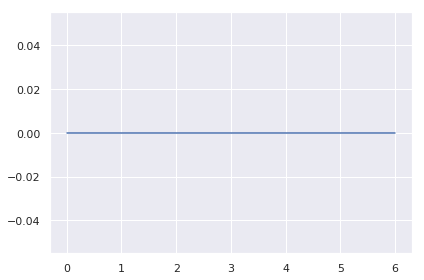

In [6]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [7]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./sac_breakout_result.gif', writer='imagemagick', fps=30)

In [ ]:
env = wrap(gym.make('MontezumaRevengeNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
frames = []

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a = sac.choose_action(np.expand_dims(s,axis=0))
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyubkim/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: <class 'wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
  warnings.warn(colorize('%s: %s'%('WARN', msg

Total Reward : 0.00


![alt text](./sac_breakout_result.gif "segment")